In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile

from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat

tf.keras.backend.set_floatx('float64')
sunspots_file = "sunspots.csv"

# Download data

In [2]:
url = "https://storage.googleapis.com/kagglesdsdata/datasets/2418/917074/Sunspots.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586472062&Signature=CC1HrFyLjRKiYDaHQuTQ6enN0a%2FP%2FLZYhVbIeSHi5zxOsKhNZmWsuCVPOIiZNzv6%2FqjQYTKFD2jNvF1qxtYN%2BKzPH0POT8Q4hjBgF%2BFj4GFVOtWsLP5JJqFzI46u9IZpJrSbnRu7rpIe5D%2FBovopNOpbp0zSpkoTTAIEDMJcQ%2BeRrYdFPKxe8CPr4gou7AzYW%2FC3zxDVxXAO8iJotXGIlkgDuzb2fFR425fNGd69QUFaZl0brcAA5ASywqbutGufRVkiJQWN6ig9t%2B3zvBDy0pf%2F%2FQBsLnCWb791uVSawwfkg8jQeLep%2Fej0%2BMwWXJQovnxNry1WKFe6dpoBQPZrlw%3D%3D&response-content-disposition=attachment%3B+filename%3DSunspots.csv"
urlretrieve(url, sunspots_file)

('sunspots.csv', <http.client.HTTPMessage at 0x7f91685500b8>)

# Read data

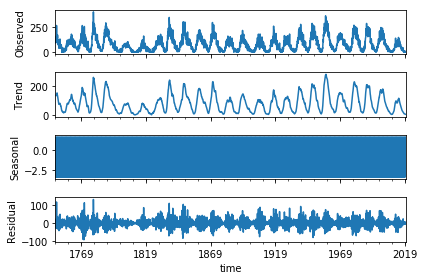

In [7]:
import datetime
import pandas as pd
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

time_series = []
with open(sunspots_file, "r") as f:
    f.readline()
    for line in f:
        line = line.strip()
        i, date, mean = line.split(',')
        mean = float(mean)
        date = datetime.datetime.strptime(date, "%Y-%m-%d")
        time_series.append((date, mean))
        

df = pd.DataFrame(time_series, columns=['time','data']).set_index('time')

decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

# Split train test

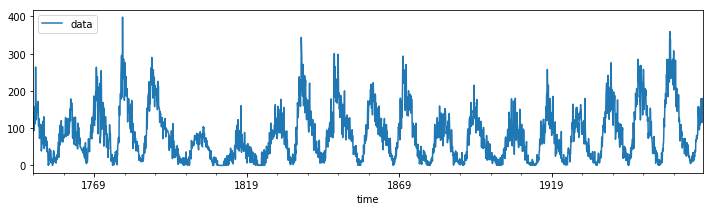

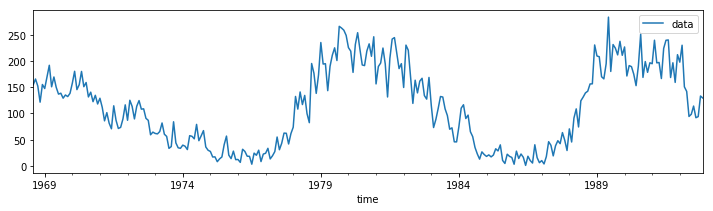

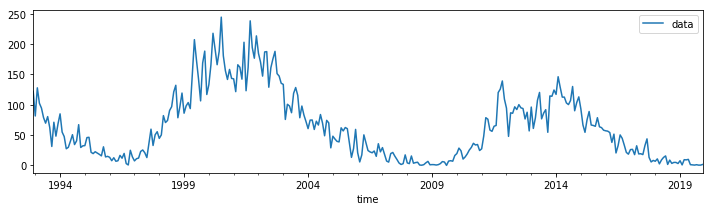

In [16]:
series_len = len(df)
test_len = int(series_len * 0.1)
train_len = series_len - test_len
val_len = int(train_len * 0.1)
train = df.iloc[:-test_len, :]
test = df.iloc[-test_len:, :]
val = train.iloc[-val_len:, :]
train = train.iloc[:-val_len, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
train.plot(figsize=(12,3))
val.plot(figsize=(12,3))
test.plot(figsize=(12,3))
plt.show()

# Arima

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observations:                 2634
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12285.029
Method:                       css-mle   S.D. of innovations             25.662
Date:                Fri, 10 Apr 2020   AIC                          24584.057
Time:                        14:32:55   BIC                          24625.191
Sample:                    02-28-1749   HQIC                         24598.951
                         - 07-31-1968                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0153      0.239      0.064      0.949      -0.454       0.485
ar.L1.D.data    -0.4165      0.019    -21.425      0.000      -0.455      -0.378
ar.L2.D.data    -0.2947      0.021    -14.06

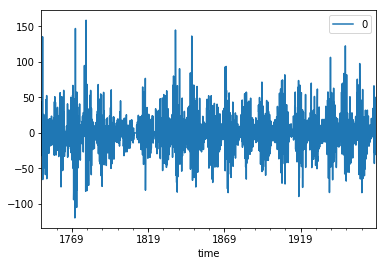

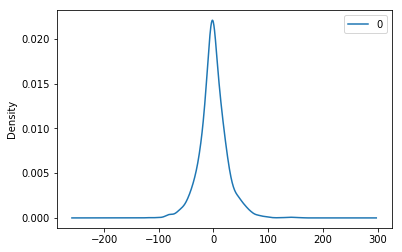

In [10]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()

In [11]:
from sklearn.metrics import  mean_squared_error 

X = df.values
size = int(len(X) * 0.8)
train_values, test_values = X[0:size], X[size:len(X)]
history = [x for x in train_values]
arima_predictions = list()
for t in range(len(test_values)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_values[t]
    history.append(obs)

error = mean_squared_error(test_values, arima_predictions)
print('Test MSE: %.3f' % error)

plt.plot(test_values)
plt.plot(arima_predictions, color='red')
plt.show()

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Test MSE: 538.131


NameError: name 'pyplot' is not defined

# RNN model

In [17]:
def create_dataset(series, time_steps):
    X = []
    y = []
    for i in range(len(series) - time_steps):
        x = series[i:i + time_steps]
        x = np.array(x).reshape(time_steps, 1)
        prediction = series[i + time_steps]
        X.append(x)
        y.append(prediction)
    return np.array(X), np.array(y)

time_steps = 25
x_train, y_train = create_dataset(list(train.values), time_steps)
x_val, y_val = create_dataset(list(val.values), time_steps)
x_test, y_test = create_dataset(list(test.values), time_steps)

print(x_train.shape)
print("Train size: %d, test size: %d, val size: %d" % (len(x_train), len(x_test), len(x_val)))

(2610, 25, 1)
Train size: 2610, test size: 300, val size: 267


In [29]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTMCell, RNN, GRU, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, InputLayer, concatenate, SpatialDropout1D, Flatten

batch_size = 32
series_input = Input(shape=(time_steps, 1, ))

cells = [
    LSTMCell(64),
    LSTMCell(64),
    LSTMCell(128),
]

model = RNN(cells)(series_input)
model = Dropout(0.3)(model)
model = Dense(128)(model)
model = Dense(64)(model)
prediction = Dense(1)(model)
model = Model(series_input, prediction)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 25, 1)]           0         
_________________________________________________________________
rnn_3 (RNN)                  (None, 128)               148736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 173,569
Trainable params: 173,569
Non-trainable params: 0
_____________________________________________________

In [32]:
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 2610 samples, validate on 267 samples
Epoch 1/5
 864/2610 [========>.....................] - ETA: 34s - loss: 19.8925

KeyboardInterrupt: 

In [33]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 2s 6ms/sample - loss: 13.8501


13.850085470930983

Test MSE: 439.917


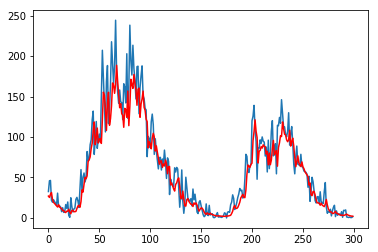

In [35]:
predictions = model.predict(x_test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()